<a href="https://colab.research.google.com/github/akbism/COVID-QA/blob/main/ImprovedInference/8_Improved_inference_with_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an improved script for prediction on unseen datasets. The script calculates various scores for "No answer predictions besides predicting answers to the questions.This script also helps in detailed analysis of final predictions.

#Setting up the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/LJMU/covidqa/biobert-pytorch/question-answering/20210711
!pip install tqdm==4.41.1
!pip install transformers datasets

Mounted at /content/gdrive
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/question-answering/20210711'
/content
     |████████████████████████████████| 56 kB 4.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.0
    Uninstalling tqdm-4.62.0:
      Successfully uninstalled tqdm-4.62.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.41.1 which is incompatible.
     |████████████████████████████████| 2.6 MB 14.1 MB/s 
     |████████████████████████████████| 264 kB 65.7 MB/s 
     |████████████████████████████████| 636 kB 57.0 MB/s 
     |████████████████████████████████| 895 kB 62.3 MB/s 
     |████████████████████████████████| 3.3 MB 55.3 MB/s 
     |████████████████████████████████| 243 kB 67.8 MB/s 
     |████████████████████

#Setting the parameters of the prediction



In [ ]:
import os
from tqdm.auto import tqdm
import pandas as pd
import datasets, collections
import numpy as np
import pickle 
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk, load_metric, load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer 
from transformers.data.metrics.squad_metrics import squad_evaluate

class eval_Args:
  data_dir = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA' #'/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/SQuAD' #  #
  train_file = 'COVID-QA-Modified-Modified.json'  #'dev-v2.0_modified.json' # #  # 'train-v2.0_modified.json' #  #  
  raw_predict_file = 'COVID-QA-Modified.json' #'dev-v2.0.json' #'COVID-QA-Modified.json' #'COVID-QA-Modified-Modified.json'  #  #  'COVID-QA-Modified-Modified.json' # 
  predict_file = 'COVID-QA-Modified-Modified.json' #'dev-v2.0_modified.json' # 'COVID-QA-Modified-Modified.json' #'COVID-QA-Modified-Modified.json'  # 'dev-v2.0_modified.json' #  'COVID-QA-Modified-Modified.json' # 
  model_name = '/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/experiments/case_12_1_3/TPU/result_d/checkpoint-1600'  #'deepset/roberta-base-squad2' #checkpoint-2000
  mix_data_path = '/content/gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/covid_bioasq_mix'
  max_length = 384 # The maximum length of a feature (question and context)
  batch_size = 16
  doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
  squad_v2 = True
  tokenizer_name = 'roberta-base'
  return_overflowing_tokens=True,
  return_offsets_mapping=True,
  padding="max_length"
  n_best_size = 30
  max_answer_length = 50
  best_f1_thresh = 0

eval_args=eval_Args()


tokenizer = AutoTokenizer.from_pretrained(eval_args.tokenizer_name)
model = AutoModelForQuestionAnswering.from_pretrained(eval_args.model_name)
with open('/content/gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/COVID-QA_Q_Types_Val.pkl', 'rb') as fid:
     covid_qtype = pickle.load(fid)

pad_on_right = tokenizer.padding_side == "right"

training_args = TrainingArguments(
output_dir='./results',
do_eval = True)
training_args = TrainingArguments(
output_dir='./results',
do_eval = True)
trainer = Trainer(
model=model,
args=training_args)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Define important functions

In [ ]:
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    args=eval_Args()
    # import pdb
    # pdb.set_trace()
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=args.max_length,
        stride=args.doc_stride,
        return_overflowing_tokens=args.return_overflowing_tokens,
        return_offsets_mapping=args.return_offsets_mapping,
        padding=args.padding,
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
def prediction_probabilities(predictions, score):
    all_scores = [x[score] for x in predictions] 
    return softmax(np.array(all_scores))

def postprocess_qa_predictions_improved(args, examples, features, raw_predictions):
    n_best_size = args.n_best_size
    max_answer_length = args.max_answer_length
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()
    best_ans_scores = collections.OrderedDict()


    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        null_scores = []
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # print("length:", len(feature_indices))
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score
            # print(min_null_score, feature_null_score)
            null_scores.append(feature_null_score)
            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {   
                            "null_score":feature_null_score, #added
                            "min_null_score":min_null_score, #added
                            "score": (start_logits[start_index] + end_logits[end_index]),
                            "text": context[start_char: end_char]
                        }
                    )
        # import pdb
        # pdb.set_trace()


        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
            
            answer_probabilities = prediction_probabilities(valid_answers, 'score')         
            best_answer_probability = answer_probabilities[np.argmax(answer_probabilities)]
            # no_answer_probabilities = prediction_probabilities(valid_answers, 'null_score')      
            # no_answer_proability = no_answer_probabilities[np.argmax(answer_probabilities)]
            # best_ans_score = {"best_answer_probability": best_answer_probability, "no_answer_proability" : no_answer_proability, "start_plus_end_logit": best_answer['score'], "null_score":best_answer['null_score'], "min_null_score":min_null_score }
            best_ans_score = {"best_answer_probability": best_answer_probability,  "start_plus_end_logit": best_answer['score'], "null_score":best_answer['null_score'], "min_null_score":min_null_score }
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

            best_ans_score = {"best_answer_probability": 0, "start_plus_end_logit":0, "null_score":999 , "min_null_score":min_null_score}
        # print(example["id"], best_answer["score"],type(best_answer["score"]), min_null_score, type(min_null_score))
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not args.squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer
            best_ans_scores[example["id"]] = best_ans_score


    return predictions, best_ans_scores

def format_and_score(args, qa_df, final_predictions): 
  # import pdb
  # pdb.set_trace()
  metric = load_metric("squad_v2" if args.squad_v2 else "squad")
  if args.squad_v2:
    formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
  else:
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in qa_df]
  return metric.compute(predictions=formatted_predictions, references=references)

def get_eval_metrics():

  args=eval_Args()
  val_input_filename = os.path.join(args.data_dir, args.predict_file)
  if args.train_file is None:
    train_input_filename = val_input_filename
  else:
    train_input_filename = os.path.join(args.data_dir, args.train_file)

  print("*** Reading Data ***")
  qa_data = load_dataset("json", data_files={"train": train_input_filename, "validation": val_input_filename} )

  qa_data = qa_data.filter(lambda example, indice: indice != 107709, with_indices=True)
  # qa_data['train']=qa_data['train'].select(range(2_000)) 
  # qa_data['validation']=qa_data['validation'].select(range(1_000)) 

  qa_data_features = qa_data.map(
      prepare_validation_features,
      batched=True,
      remove_columns=qa_data["validation"].column_names)
  #### squad v1 will give error 
  model_name=args.model_name
  # result= pd.DataFrame( columns=['exact', 'f1', 'total', 'HasAns_exact', 'HasAns_f1', 'HasAns_total', 'best_exact', 'best_exact_thresh', 'best_f1', 'best_f1_thresh', 'model_name', 'split'])
  result= pd.DataFrame( columns=['exact', 'f1', 'total', 'HasAns_exact', 'HasAns_f1', 'HasAns_total','NoAns_exact','NoAns_f1','NoAns_total', 'best_exact', 'best_exact_thresh', 'best_f1', 'best_f1_thresh', 'model_name', 'split'])
  model = AutoModelForQuestionAnswering.from_pretrained(model_name)
  trainer = Trainer(
  model=model,
  args=training_args)

  print("*** Prediction, postprocessing and formatting ***")

  val_raw_predictions = trainer.predict(qa_data_features['validation'])
  val_final_predictions = postprocess_qa_predictions(args, qa_data["validation"], qa_data_features['validation'], val_raw_predictions.predictions)
  val_score=format_and_score(args, qa_data["validation"], val_final_predictions)  
  # import pdb
  # pdb.set_trace()
  if args.train_file is None:
    train_score = val_score
  else:
    train_raw_predictions = trainer.predict(qa_data_features['train'])
    train_final_predictions = postprocess_qa_predictions(args,qa_data["train"], qa_data_features['train'], train_raw_predictions.predictions)
    train_score=format_and_score(args, qa_data["train"],  train_final_predictions)  
  
  val_score['model_name'] = args.model_name
  val_score['split'] ='validation'
  train_score['model_name'] =args.model_name
  train_score['split'] ='train'
  # print(checkpoint)
  # import pdb
  # pdb.set_trace()
  temp=pd.concat([pd.DataFrame.from_dict(val_score, orient='index').T, pd.DataFrame.from_dict(train_score, orient='index').T]).reset_index()
  result=result.append(temp)
  return result

In [ ]:
def prepare_validation_features(examples, args=eval_args):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=args.max_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
def get_prediction(args, data, trainer, qid):
    inputs = data.filter(lambda example: example['id']==qid).map(
      prepare_validation_features,
      batched=True,
      remove_columns=data.column_names)
    data = data.filter(lambda example: example['id']==qid) 
    # import pdb
    # pdb.set_trace()
    # outputs = model(**inputs)
    raw_predictions = trainer.predict(inputs)
    outputs=raw_predictions.predictions
    predictions = postprocess_qa_predictions_improved(args, data, inputs, raw_predictions.predictions)
    # print("f1 threshold:", args.best_f1_thresh)
    # answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    # answer_end = torch.argmax(outputs[1]) + 1 

    # answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return predictions
  
def get_prediction_all(args, data, trainer):
    inputs = data.map(
      prepare_validation_features,
      batched=True,
      remove_columns=data.column_names)
    # import pdb
    # pdb.set_trace()
    # outputs = model(**inputs)
    raw_predictions = trainer.predict(inputs)
    outputs=raw_predictions.predictions
    predictions = postprocess_qa_predictions_improved(args, data, inputs, raw_predictions.predictions)
    # print("f1 threshold:", args.best_f1_thresh)
    # answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    # answer_end = torch.argmax(outputs[1]) + 1 

    # answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    return predictions

#Load Dataset

In [ ]:
qa_data = load_from_disk(eval_args.mix_data_path)

#Prediction of the COVID-QA(60%) dataset

In [ ]:
qa_val = qa_data['validation']#.select(range(500)) 
predictions, scores = get_prediction_all(eval_args, qa_val, trainer)
pred = pd.DataFrame(list(predictions.items()), columns=['id', 'prediction'])
temp=[(x[0], x[1]['best_answer_probability'],x[1]['start_plus_end_logit'] ,x[1]['null_score'],x[1]['min_null_score']) for x in list(scores.items())]
all_scores = pd.DataFrame(temp, columns=['id', 'best_answer_probability','start_plus_end_logit','null_score','min_null_score'])
all_pred= pred.merge(all_scores, left_on="id", right_on="id", how='left')

Loading cached processed dataset at /content/gdrive/My Drive/Colab Notebooks/LJMU/covidqa/biobert-pytorch/datasets/QA/covid_bioasq_mix/validation/cache-e2dc89c0214a07ac.arrow
The following columns in the test set  don't have a corresponding argument in `RobertaForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping.
***** Running Prediction *****
  Num examples = 37857
  Batch size = 8


In [ ]:
display(all_pred)

,id,prediction,best_answer_probability,start_plus_end_logit,null_score,min_null_score
0,3946,worsens the classical symptoms of disease and ...,0.216627,11.140284,4.325426,10.617400
1,3033,,0.597645,3.497216,6.412642,9.987829
2,3733,,0.198567,3.453665,6.579865,10.368435
3,3894,due to the current scarcity of antiviral drugs...,0.260753,12.157158,7.455410,10.603855
4,4100,,0.204461,7.826268,9.657146,10.235701
...,...,...,...,...,...,...
1207,3991,,0.325380,10.162078,9.971464,10.310549
1208,5306,labeled with Cell-Tracker Green CMFDA Dye,0.161227,13.152126,2.873197,10.123105
1209,4176,,0.143963,9.767177,4.126191,10.880445
1210,4301,acute LRT disease in a healthcare setting in J...,0.188262,14.539293,3.928383,10.242661


In [ ]:
df = pd.DataFrame(qa_data['validation'])
df['answers'] = df['answers'].map(lambda x: x['text'][0])
df1=df.merge(all_pred, left_on='id', right_on = 'id')
df1=df1.merge(covid_qtype, left_on='id', right_on = 'id', how ='left')



#Adding no answer additional features

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/Colab Notebooks/LJMU/covidqa/experiments/covid_no_ans_features_prob.pkl', 'rb') as fid:
     covid_no_ans_prob = pickle.load(fid)
covid_no_ans_prob.index = covid_no_ans_prob.index.set_names(['id'])
covid_no_ans_prob= covid_no_ans_prob.reset_index()

df1=df1.merge(covid_no_ans_prob, left_on='id', right_on = 'id', how ='left')
df1['no_answer_found']=df1['prediction']==''

In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
df1[1:10]

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


,id,title,context,question,answers,is_impossible,prediction,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction,no_answer_probability,no_answer_found
1,3033,Dummy,"Acute Hemorrhagic Encephalitis Responding to Combined Decompressive Craniectomy, Intravenous Immunoglobulin, and Corticosteroid Therapies: Association with Novel RANBP2 Variant\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5857578/\n\nSHA: ef6638accc1ef599ad1aafd47b3a86f2b904cc76\n\nAuthors: Alawadhi, Abdulla; Saint-Martin, Christine; Bhanji, Farhan; Srour, Myriam; Atkinson, Jeffrey; Sébire,...",What are the salient findings in Acute hemorrhagic encephalomyelitis?,fulminant encephalopathy with hemorrhagic necrosis,False,,0.597645,3.497216,6.412642,9.987829,DESC,3,0,1,1,0,0,0,0,1.0,0.0,0.0,0.356751,True
2,3733,Dummy,"Genomic characterization of the 2019 novel human-pathogenic coronavirus isolated from a patient with atypical pneumonia after visiting Wuhan\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7067204/\n\nSHA: c097a8a9a543d69c34f10e5c3fd78019e560026a\n\nAuthors: Chan, Jasper Fuk-Woo; Kok, Kin-Hang; Zhu, Zheng; Chu, Hin; To, Kelvin Kai-Wang; Yuan, Shuofeng; Yuen, Kwok-Yung\nDate: 2020-01-28\nDOI: 1...",From where have the original SARS-CON orf8 been acquired?,two bat SARS-related-CoV (Bat-CoV YNLF_31C and YNLF_34C),False,,0.198567,3.453665,6.579865,10.368435,LOC,29,3,0,0,0,0,0,0,0.0,0.0,1.0,0.910309,True
3,3894,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",Why is this approach significant?,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations.,False,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations,0.260753,12.157158,7.455410,10.603855,DESC,3,0,0,0,0,0,1,0,0.0,0.0,0.0,0.462267,False
4,4100,Dummy,"Etiology of Influenza-Like Illnesses from Sentinel Network Practitioners in Réunion Island, 2011-2012\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5031398/\n\nSHA: f5ff89ebfdd0375d034c112c6c1c7e163fa69a0c\n\nAuthors: Brottet, Elise; Jaffar-Bandjee, Marie-Christine; Li-Pat-Yuen, Ghislaine; Filleul, Laurent\nDate: 2016-09-21\nDOI: 10.1371/journal.pone.0163377\nLicense: cc-by\n\nAbstract: In R...",What are the objectives of the study?,"to characterize respiratory pathogens responsible for ILI consultations in sentinel GPs in 2011 and 2012. Secondary objectives were to highlight seasonal trends on respiratory pathogens circulation and to describe occurrence of co-infections, especially during the flu season.",False,,0.204461,7.826268,9.657146,10.235701,DESC,5,1,0,1,0,0,0,0,0.0,0.0,1.0,0.533255,True
5,3891,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",How may the responses be different in a chronically inflamed airway?,"the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms (Mallia and Johnston, 2006; Dougherty and Fahy, 2009; Busse et al., 2010; Britto et al., 2017; Linden et al., 2019) . This is usually further compounded by the increased susceptibility of chronic airway inflammatory disease pat...",False,"the responses against the viru

In [ ]:
df1.columns

Index(['id', 'title', 'context', 'question', 'answers', 'is_impossible',
       'prediction', 'best_answer_probability', 'start_plus_end_logit',
       'null_score', 'min_null_score', 'question_type', 'PRODUCT', 'LAW',
       'TIME', 'what', 'when', 'how', 'why', 'who', 'percentage NNP',
       'percentage CD', 'no_answer_prediction', 'no_answer_probability',
       'no_answer_found'],
      dtype='object')

In [ ]:
df1[df1.prediction!=''][['id','context', 'question', 'answers', 'prediction', 'no_answer_probability' ,'best_answer_probability', 'start_plus_end_logit',
       'null_score', 'min_null_score', 'question_type', 'PRODUCT', 'LAW',
       'TIME', 'what', 'when', 'how', 'why', 'who', 'percentage NNP',
       'percentage CD', 'no_answer_prediction']]

,id,context,question,answers,prediction,no_answer_probability,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction
0,3946,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",What is the result of increased eosinophilia?,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,0.456500,0.216627,11.140284,4.325426,10.617400,DESC,3,0,0,1,0,0,0,0,0.000000,0.000000,0.0
3,3894,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",Why is this approach significant?,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations.,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations,0.462267,0.260753,12.157158,7.455410,10.603855,DESC,3,0,0,0,0,0,1,0,0.000000,0.000000,0.0
5,3891,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",How may the responses be different in a chronically inflamed airway?,"the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms (Mallia and Johnston, 2006; Dougherty and Fahy, 2009; Busse et al., 2010; Britto et al., 2017; Linden et al., 2019) . This is usually further compounded by the increased susceptibility of chronic airway inflammatory disease pat...","the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms",0.405557,0.102475,13.004876,5.796035,10.615196,DESC,3,0,0,0,0,1,0,0,0.000000,0.000000,0.0
8,4555,"Hantaviruses in the Americas and Their Role as Emerging Pathogens\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC3185593/\n\nSHA: efe13a8d42b60ef9f7387ea539a1b2eeb5f80101\n\nAuthors: Hjelle, Brian; Torres-Pérez, Fernando\nDate: 2010-11-25\nDOI: 10.3390/v2122559\nLicense: cc-by\n\nAbstract: The continued emergence and re-emergence of pathogens represent an ongoing, sometimes major, threat to p...",What do those abnormalities sometimes culminate in?,shock and death,in shock and death,0.814419,0.377809,15.181065,6.403478,10.374342,ENTY,19,1,0,1,0,0,0,0,0.000000,0.000000,1.0
11,2968,"Epidemiological research priorities for public health control of the ongoing global novel coronavirus (2019-nCoV) outbreak\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7029449/\n\nSHA: 90de2d957e1960b948b8c38c9877f9eca983f9eb\n\nAuthors: Cowling, Benjamin J; Leung, Gabriel M\nDate: 2020-02-13\nDOI: 10.2807/1560-7917.es.2020.25.6.2000110\nLicense: cc-by\n\nAbstract: Infections with 2019-nCoV...",What is the estimate of the basic reproduction number?,2.2,2.2,0.534793,0.329071,12.795593,7.970959,10.8071

In [ ]:
df1[df1.prediction!=''][['id','context', 'question', 'answers', 'prediction', 'no_answer_probability' ,'best_answer_probability', 'start_plus_end_logit',
       'null_score', 'min_null_score', 'question_type', 'PRODUCT', 'LAW',
       'TIME', 'what', 'when', 'how', 'why', 'who', 'percentage NNP',
       'percentage CD', 'no_answer_prediction']]

,id,context,question,answers,prediction,no_answer_probability,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction
0,3946,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",What is the result of increased eosinophilia?,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,0.456500,0.216627,11.140284,4.325426,10.617400,DESC,3,0,0,1,0,0,0,0,0.000000,0.000000,0.0
3,3894,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",Why is this approach significant?,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations.,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations,0.462267,0.260753,12.157158,7.455410,10.603855,DESC,3,0,0,0,0,0,1,0,0.000000,0.000000,0.0
5,3891,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",How may the responses be different in a chronically inflamed airway?,"the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms (Mallia and Johnston, 2006; Dougherty and Fahy, 2009; Busse et al., 2010; Britto et al., 2017; Linden et al., 2019) . This is usually further compounded by the increased susceptibility of chronic airway inflammatory disease pat...","the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms",0.405557,0.102475,13.004876,5.796035,10.615196,DESC,3,0,0,0,0,1,0,0,0.000000,0.000000,0.0
8,4555,"Hantaviruses in the Americas and Their Role as Emerging Pathogens\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC3185593/\n\nSHA: efe13a8d42b60ef9f7387ea539a1b2eeb5f80101\n\nAuthors: Hjelle, Brian; Torres-Pérez, Fernando\nDate: 2010-11-25\nDOI: 10.3390/v2122559\nLicense: cc-by\n\nAbstract: The continued emergence and re-emergence of pathogens represent an ongoing, sometimes major, threat to p...",What do those abnormalities sometimes culminate in?,shock and death,in shock and death,0.814419,0.377809,15.181065,6.403478,10.374342,ENTY,19,1,0,1,0,0,0,0,0.000000,0.000000,1.0
11,2968,"Epidemiological research priorities for public health control of the ongoing global novel coronavirus (2019-nCoV) outbreak\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7029449/\n\nSHA: 90de2d957e1960b948b8c38c9877f9eca983f9eb\n\nAuthors: Cowling, Benjamin J; Leung, Gabriel M\nDate: 2020-02-13\nDOI: 10.2807/1560-7917.es.2020.25.6.2000110\nLicense: cc-by\n\nAbstract: Infections with 2019-nCoV...",What is the estimate of the basic reproduction number?,2.2,2.2,0.534793,0.329071,12.795593,7.970959,10.8071

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=67bebc5e4b01a0b165462752d0adeab0fd0d136034e424c26637c3c474723f25
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
df1_with_ans= df1[df1.prediction!='']

In [ ]:
df1_with_ans.head()

,id,title,context,question,answers,is_impossible,prediction,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction,no_answer_probability,no_answer_found
0,3946,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",What is the result of increased eosinophilia?,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,False,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,0.216627,11.140284,4.325426,10.617400,DESC,3,0,0,1,0,0,0,0,0.0,0.0,0.0,0.456500,False
3,3894,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",Why is this approach significant?,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations.,False,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations,0.260753,12.157158,7.455410,10.603855,DESC,3,0,0,0,0,0,1,0,0.0,0.0,0.0,0.462267,False
5,3891,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",How may the responses be different in a chronically inflamed airway?,"the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms (Mallia and Johnston, 2006; Dougherty and Fahy, 2009; Busse et al., 2010; Britto et al., 2017; Linden et al., 2019) . This is usually further compounded by the increased susceptibility of chronic airway inflammatory disease pat...",False,"the responses against the virus may be impaired or aberrant, causing sustained inflammation and erroneous infiltration, resulting in the exacerbation of their symptoms",0.102475,13.004876,5.796035,10.615196,DESC,3,0,0,0,0,1,0,0,0.0,0.0,0.0,0.405557,False
8,4555,Dummy,"Hantaviruses in the Americas and Their Role as Emerging Pathogens\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC3185593/\n\nSHA: efe13a8d42b60ef9f7387ea539a1b2eeb5f80101\n\nAuthors: Hjelle, Brian; Torres-Pérez, Fernando\nDate: 2010-11-25\nDOI: 10.3390/v2122559\nLicense: cc-by\n\nAbstract: The continued emergence and re-emergence of pathogens represent an ongoing, sometimes major, threat to p...",What do those abnormalities sometimes culminate in?,shock and death,False,in shock and death,0.377809,15.181065,6.403478,10.374342,ENTY,19,1,0,1,0,0,0,0,0.0,0.0,1.0,0.814419,False
11,2968,Dummy,"Epidemiological research priorities for public health control of the ongoing global novel coronavirus (2019-nCoV) outbreak\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7029449/\n\nSHA: 90de2d957e1960b948b8c38c9877f9eca983f9eb\n\nAuthors: Cowling, Benjamin J; Leung, Gabriel M\nDate: 2020-02-13\nDOI: 10.2807/1560-7917.es.2020.25.6.2000110\nLicense: cc-by\n\nAbstract: Infections with 2019-nCoV...",What is the estimate of the basic

#Creating additional features for analysis of the final predictions

In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')
df1['context_len']= df1['context'].apply(lambda x: len(tokenize.word_tokenize(x)))
df1['question_len']= df1['question'].apply(lambda x: len(tokenize.word_tokenize(x)))
df1['answer_len']= df1['answers'].apply(lambda x: len(tokenize.word_tokenize(x)))
df1['prediction_len']= df1['prediction'].apply(lambda x: len(tokenize.word_tokenize(x)))
df1['answer_sentence_len']= df1['answers'].apply(lambda x: len(tokenize.sent_tokenize(x)))

from fuzzywuzzy import fuzz
df1['fuzz_partial_ratio'] = df1.apply(lambda x: fuzz.partial_ratio(x['answers'], x['prediction']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Question type vs "no answer found" prediction distribution 

In [ ]:
temp = np.round(pd.crosstab(df1.question_type, df1.no_answer_found).apply(lambda r: r/r.sum(), axis=1),2)
temp

no_answer_found,False,True
question_type,,
ABBR,1.00,0.00
DESC,0.53,0.47
ENTY,0.67,0.33
HUM,0.76,0.24
LOC,0.49,0.51
NUM,0.77,0.23


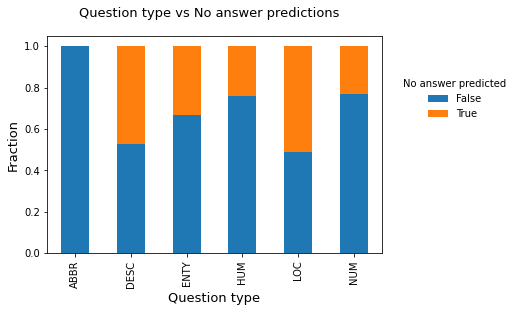

In [ ]:
import matplotlib.pyplot as plt
temp.plot.bar(stacked=True)
plt.legend(title='No answer found')
plt.suptitle('Question type vs No answer predictions', fontsize=13)
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
plt.legend(loc='lower left', bbox_to_anchor= (1.05, 0.6),borderaxespad=0, frameon=False , title="No answer predicted")
plt.xlabel('Question type', size=13)
plt.ylabel('Fraction', size=13)


plt.show()

# Analysis of non-empty answer predictions (comparision with the base model)

Text(0.5, 1.0, '(excluding "no answer" predictions)')

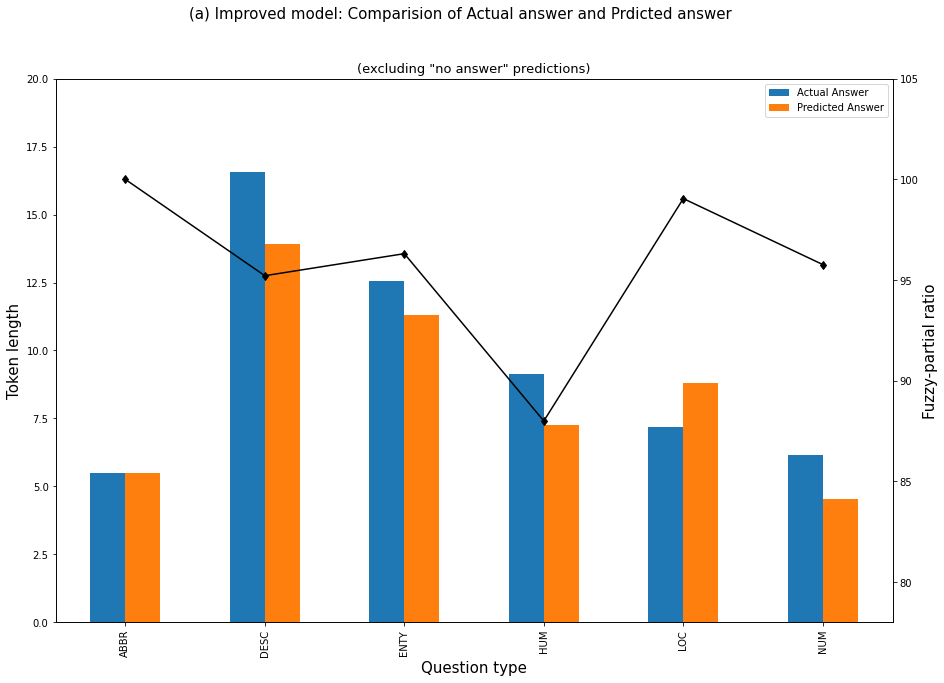

In [ ]:
temp = df1[~df1.no_answer_found].groupby('question_type').describe().loc[:,(slice(None),['mean'])][['answer_len',	'prediction_len', 'fuzz_partial_ratio']]
temp.columns = temp.columns.get_level_values(0)
temp=temp.reset_index().rename(columns= {'answer_len':"Actual Answer", "prediction_len":"Predicted Answer"})

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
temp.plot(x="question_type", y=["Actual Answer", "Predicted Answer"], kind="bar", ax=ax1)
temp['fuzz_partial_ratio'].plot(kind='line', marker='d', color='black', ax=ax2)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.set_ylabel('Token length', size=15)
ax2.set_ylabel('Fuzzy-partial ratio', size=15)

ax1.set_ylim([0,20])
ax2.set_ylim([78,105])

ax1.set_xlabel('Question type', size=15)
fig.suptitle('(a) Improved model: Comparision of Actual answer and Prdicted answer', fontsize=15)
plt.title('(excluding "no answer" predictions)', fontsize=13)

In [ ]:
# temp.plot(x="question_type", y=["answer_len", "prediction_len"], kind="bar")

Text(0.5, 0, 'Question type')

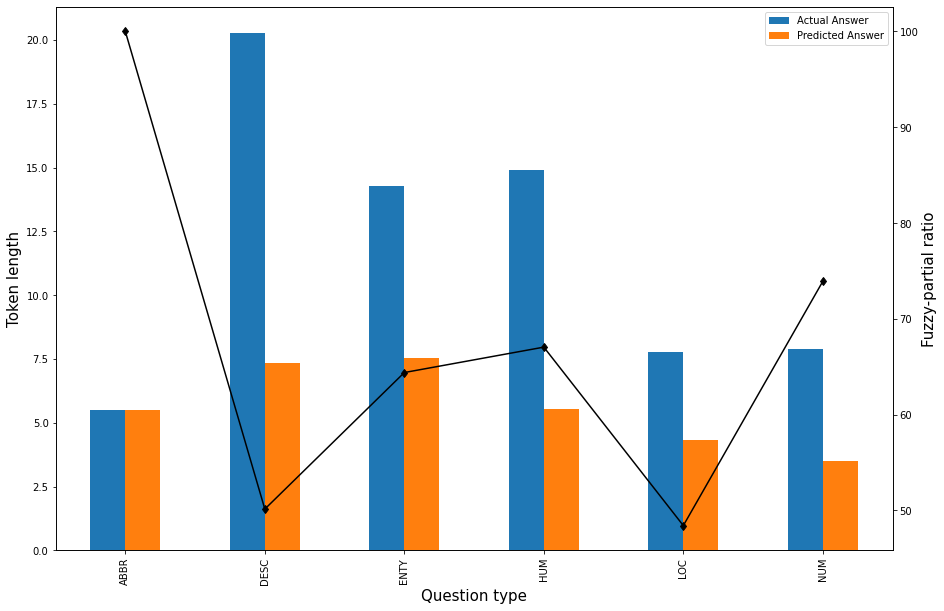

In [ ]:
temp = df1.groupby('question_type').describe().loc[:,(slice(None),['mean'])][['answer_len',	'prediction_len', 'fuzz_partial_ratio']]
temp.columns = temp.columns.get_level_values(0)
temp=temp.reset_index().rename(columns= {'answer_len':"Actual Answer", "prediction_len":"Predicted Answer"})

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
temp.plot(x="question_type", y=["Actual Answer", "Predicted Answer"], kind="bar", ax=ax1)
temp['fuzz_partial_ratio'].plot(kind='line', marker='d', color='black', ax=ax2)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.set_ylabel('Token length', size=15)
ax2.set_ylabel('Fuzzy-partial ratio', size=15)
ax1.set_xlabel('Question type', size=15)

#Describe the test dataset

In [ ]:
df1.describe().unstack(1)

best_answer_probability  count     1212.000000
                         mean         0.323127
                         std          0.192912
                         min          0.032237
                         25%          0.182887
                         50%          0.272282
                         75%          0.426040
                         max          0.993623
start_plus_end_logit     count     1212.000000
                         mean        10.418038
                         std          4.173810
                         min         -9.078561
                         25%          8.087901
                         50%         11.665174
                         75%         13.559327
                         max         16.693565
null_score               count     1212.000000
                         mean         6.055254
                         std          1.899474
                         min          1.270214
                         25%          4.563991
             

# Describe the test dataset groupwise ("no_answer_found")

In [ ]:
df1.groupby('no_answer_found').describe().unstack(1)

                                no_answer_found
best_answer_probability  count  False                741.000000
                                True                 471.000000
                         mean   False                  0.342650
                                True                   0.292414
                         std    False                  0.195139
                                True                   0.185439
                         min    False                  0.057944
                                True                   0.032237
                         25%    False                  0.194329
                                True                   0.156195
                         50%    False                  0.295083
                                True                   0.237829
                         75%    False                  0.445582
                                True                   0.374497
                         max    False                  0

# Distribution fo Question type vs count of "No answer found"

In [ ]:
pd.crosstab(df1['question_type'], df1['no_answer_found']).reset_index()

no_answer_found,question_type,False,True
0,ABBR,2,0
1,DESC,316,284
2,ENTY,226,112
3,HUM,16,5
4,LOC,22,23
5,NUM,159,47


In [ ]:
df1.groupby(['question_type']).agg({'fuzz_partial_ratio':'mean'})

,fuzz_partial_ratio
question_type,
ABBR,100.000000
DESC,50.146667
ENTY,64.396450
HUM,67.047619
LOC,48.422222
NUM,73.917476


In [ ]:
df1.groupby(['question_type']).agg({'answer_len':'mean'})

,answer_len
question_type,
ABBR,5.500000
DESC,20.288333
ENTY,14.292899
HUM,14.904762
LOC,7.755556
NUM,7.898058


In [ ]:
df1[df1.question_type=='LOC']

,id,title,context,question,answers,is_impossible,prediction,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction,no_answer_probability,no_answer_found,context_len,question_len,answer_len,prediction_len,answer_sentence_len,fuzz_partial_ratio
2,3733,Dummy,"Genomic characterization of the 2019 novel human-pathogenic coronavirus isolated from a patient with atypical pneumonia after visiting Wuhan\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7067204/\n\nSHA: c097a8a9a543d69c34f10e5c3fd78019e560026a\n\nAuthors: Chan, Jasper Fuk-Woo; Kok, Kin-Hang; Zhu, Zheng; Chu, Hin; To, Kelvin Kai-Wang; Yuan, Shuofeng; Yuen, Kwok-Yung\nDate: 2020-01-28\nDOI: 1...",From where have the original SARS-CON orf8 been acquired?,two bat SARS-related-CoV (Bat-CoV YNLF_31C and YNLF_34C),False,,0.198567,3.453665,6.579865,10.368435,LOC,29,3,0,0,0,0,0,0,0.0,0.0,1.0,0.910309,True,2785,10,9,0,1,0
58,4393,Dummy,"Optimization Method for Forecasting Confirmed Cases of COVID-19 in China\n\nhttps://doi.org/10.3390/jcm9030674\n\nSHA: 1d7f8850c5244fdc9b387038e7eeae9bcbbde6d2\n\nAuthors: Al-Qaness, Mohammed A. A.; Ewees, Ahmed A.; Fan, Hong; Abd El Aziz, Mohamed\nDate: 2020\nDOI: 10.3390/jcm9030674\nLicense: cc-by\n\nAbstract: In December 2019, a novel coronavirus, called COVID-19, was discovered in Wuhan, C...",Where was the coronavirus discovered?,"Wuhan, China",False,"Wuhan, China",0.326856,12.962267,4.299884,10.068487,LOC,13,4,0,0,0,0,0,0,0.0,0.0,1.0,0.709879,False,3998,6,3,3,1,100
69,280,Dummy,"Severe Acute Respiratory Syndrome Coronavirus Viroporin 3a Activates the NLRP3 Inflammasome\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC6361828/\n\nSHA: f02d0c1e8b0109648e578662dc250abe349a033c\n\nAuthors: Chen, I-Yin; Moriyama, Miyu; Chang, Ming-Fu; Ichinohe, Takeshi\nDate: 2019-01-29\nDOI: 10.3389/fmicb.2019.00050\nLicense: cc-by\n\nAbstract: Nod-like receptor family, pyrin domain-contai...",Where does the NLRP3 inflammasome activate after a SARS-CoV infection?,in lipopolysaccharide-primed macrophages,False,in lipopolysaccharide-primed macrophages,0.445582,13.270210,4.102604,10.227582,LOC,22,3,1,0,0,0,0,0,1.0,0.0,1.0,0.773726,False,4317,11,3,3,1,100
108,4175,Dummy,"MERS coronavirus: diagnostics, epidemiology and transmission\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC4687373/\n\nSHA: f6fcf1a99cbd073c5821d1c4ffa3f2c6daf8ae29\n\nAuthors: Mackay, Ian M.; Arden, Katherine E.\nDate: 2015-12-22\nDOI: 10.1186/s12985-015-0439-5\nLicense: cc-by\n\nAbstract: The first known cases of Middle East respiratory syndrome (MERS), associated with infection by a novel...",Where was the the case first to be publicly reported was from ?,"Jeddah, in the Kingdom of Saudi Arabia (KSA)",False,Jeddah,0.213079,14.413996,4.315812,10.449814,LOC,13,0,1,0,0,0,0,0,0.0,0.0,1.0,0.580285,False,13195,13,11,1,1,100
120,529,Dummy,"Note from the editors: novel coronavirus (2019-nCoV)\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC6988271/\n\nSHA: d958168df85240e544a918d843a14e887dc41d2b\n\nAuthors: nan\nDate: 2020-01-23\nDOI: 10.2807/1560-7917.es.2020.25.3.2001231\nLicense: cc-by\n\nAbstract: nan\n\nText: The situation has continued to evolve rapidly since then and just a few weeks later, as at 23 January, 614 laborator...",Where can published genomic sequences be found for the 2019-nCoV virus?,Global Initiative on Sharing All Influenza Data (GISAID) (https://www.gisaid.org/),False,,0.220324,8.124866,7.059513,10.424758,LOC,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.331577,True,483,12,15,0,1,0
180,1600,Dummy,"Etiology of respiratory tract infections in the community and clinic in Ilorin, Nigeria\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5719735/\n\nSHA: f2e835d2cde5f42054dbd0c20d4060721135c518\n\nAuthors: Kolawole, Olatunji; Oguntoye, Michael; Dam, Tina; Chunara, Rumi\nDate: 2017-12-07\nDOI: 10.1186/s13104-017-3063-1\nLicense: cc-by\n\nAbstract: OBJECTIVE: Recognizing increasing interes

In [ ]:
df1[df1.question_type=='DESC']

,id,title,context,question,answers,is_impossible,prediction,best_answer_probability,start_plus_end_logit,null_score,min_null_score,question_type,PRODUCT,LAW,TIME,what,when,how,why,who,percentage NNP,percentage CD,no_answer_prediction,no_answer_probability,no_answer_found,context_len,question_len,answer_len,prediction_len,answer_sentence_len,fuzz_partial_ratio
0,3946,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",What is the result of increased eosinophilia?,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,False,worsens the classical symptoms of disease and may further lead to life-threatening conditions due to breathing difficulties,0.216627,11.140284,4.325426,10.617400,DESC,3,0,0,1,0,0,0,0,0.000000,0.0,0.0,0.456500,False,6416,8,17,17,1,100
1,3033,Dummy,"Acute Hemorrhagic Encephalitis Responding to Combined Decompressive Craniectomy, Intravenous Immunoglobulin, and Corticosteroid Therapies: Association with Novel RANBP2 Variant\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5857578/\n\nSHA: ef6638accc1ef599ad1aafd47b3a86f2b904cc76\n\nAuthors: Alawadhi, Abdulla; Saint-Martin, Christine; Bhanji, Farhan; Srour, Myriam; Atkinson, Jeffrey; Sébire,...",What are the salient findings in Acute hemorrhagic encephalomyelitis?,fulminant encephalopathy with hemorrhagic necrosis,False,,0.597645,3.497216,6.412642,9.987829,DESC,3,0,1,1,0,0,0,0,1.000000,0.0,0.0,0.356751,True,2840,10,5,0,1,0
3,3894,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",Why is this approach significant?,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations.,False,due to the current scarcity of antiviral drugs for the management of viral-induced exacerbations,0.260753,12.157158,7.455410,10.603855,DESC,3,0,0,0,0,0,1,0,0.000000,0.0,0.0,0.462267,False,6416,6,15,14,1,100
4,4100,Dummy,"Etiology of Influenza-Like Illnesses from Sentinel Network Practitioners in Réunion Island, 2011-2012\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5031398/\n\nSHA: f5ff89ebfdd0375d034c112c6c1c7e163fa69a0c\n\nAuthors: Brottet, Elise; Jaffar-Bandjee, Marie-Christine; Li-Pat-Yuen, Ghislaine; Filleul, Laurent\nDate: 2016-09-21\nDOI: 10.1371/journal.pone.0163377\nLicense: cc-by\n\nAbstract: In R...",What are the objectives of the study?,"to characterize respiratory pathogens responsible for ILI consultations in sentinel GPs in 2011 and 2012. Secondary objectives were to highlight seasonal trends on respiratory pathogens circulation and to describe occurrence of co-infections, especially during the flu season.",False,,0.204461,7.826268,9.657146,10.235701,DESC,5,1,0,1,0,0,0,0,0.000000,0.0,1.0,0.533255,True,2515,8,40,0,2,0
5,3891,Dummy,"Respiratory Viral Infections in Exacerbation of Chronic Airway Inflammatory Diseases: Novel Mechanisms and Insights From the Upper Airway Epithelium\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC7052386/\n\nSHA: 45a566c71056ba4faab425b4f7e9edee6320e4a4\n\nAuthors: Tan, Kai Sen; Lim, Rachel Liyu; Liu, Jing; Ong, Hsiao Hui; Tan, Vivian Jiayi; Lim, Hui Fang; Chung, Kian Fan; Adcock, Ian M.; Cho...",How may the responses be different in a chronically inflamed airway?,"the responses against the virus may be impaired or aberrant, causing sustaine

In [ ]:
df1.groupby(['no_answer_prediction']).agg({'fuzz_partial_ratio':'mean'})

,fuzz_partial_ratio
no_answer_prediction,
0.0,60.571992
1.0,56.961702


In [ ]:
df1.fuzz_partial_ratio.describe()

count    1212.000000
mean       58.471947
std        48.040085
min         0.000000
25%         0.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: fuzz_partial_ratio, dtype: float64